<img src='https://mundiwebservices.com/build/assets/Mundi-Logo-CMYK-colors.png'  align='left' width='15%' ></img>  

# Mundi tutorial

This notebook shows how to use various Mundi features:
* [Catalog search](#Catalog-search)
    * [via OpenSearch](#OpenSearch)
    * [via CSW](#CSW)
* [Data download](#Data-download)
    * [via boto3 (Python module)](#With-boto3)
    * [via WMS requests](#Via-WMS-requests)
* [Data cropping with GDAL](#Data-cropping)
* [Data upload into buckets](#Data-upload)

In order to use S3 buckets, please enter your access key and secret key:

In [1]:
access_key = '<your access key goes here>'
secret_key = '<your secret key goes here>'

#### Prerequisite: Create a shapefile

In order to show how to use a shapefile for catalog requests and data cropping, we need to create one.

The polygon below is the 31000 zipcode in Toulouse.

In [2]:
import os
import fiona
from fiona.crs import from_epsg
from shapely.geometry import mapping
from shapely.wkt import loads

wkt = 'POLYGON ((1.411990311657791 43.60893464678884, 1.413356637974513 43.60960085989328, 1.418455860551665 43.61097918628918, 1.424850247529802 43.61205570843603, 1.425635002940931 43.61211864405515, 1.428028875307275 43.61259805101209, 1.430088315259607 43.61313126336125, 1.431459696410796 43.61359745796707, 1.432141077432951 43.61400150356098, 1.433020578681975 43.6145203706956, 1.433994006064472 43.61521101090898, 1.435168127868253 43.61561779864146, 1.43703727417807 43.61597958893502, 1.438371609526464 43.61621531542927, 1.438960807662924 43.61621998814505, 1.43945359456159 43.61611073396749, 1.4408386942167 43.61567133828479, 1.441726727276571 43.61539542735726, 1.442615638794945 43.61517605426781, 1.443402163517029 43.61512563955516, 1.444286837762975 43.6151892330049, 1.445563631120773 43.61531243748507, 1.446841070067399 43.61549225737239, 1.447234546357979 43.61545231501231, 1.447530117599597 43.61539801416279, 1.450671709531032 43.61392608090954, 1.451517363540352 43.61339455717061, 1.452280973906952 43.6121445857071, 1.453256545328514 43.6102974610064, 1.454154788338121 43.60927060529792, 1.454810228335534 43.60876134251635, 1.456149162394154 43.60625619610916, 1.456845575765051 43.60516608850967, 1.456714767626588 43.60175814105572, 1.4565400041514 43.60109218258432, 1.457859393016933 43.60174515591665, 1.45808475973518 43.60148981359526, 1.456800519898338 43.60090633470992, 1.456872588888916 43.59812299418241, 1.457122127330665 43.59499500110569, 1.4566723320407 43.59447885208613, 1.456491184466848 43.59377719654631, 1.45379000355669 43.59471927056493, 1.452889395496327 43.59454750748264, 1.452288245830712 43.59458575256379, 1.451590375063696 43.59491634147356, 1.442013986149607 43.59175245865185, 1.436068408442264 43.59241169386775, 1.438892533622185 43.59498848608914, 1.438829584500442 43.599664707808, 1.433784366780589 43.6027897411429, 1.426913071915775 43.60341186707751, 1.418449276005953 43.60519110662955, 1.411990311657791 43.60893464678884))'

# create directory where to store shp files 
shapefile_dir = '/home/jovyan/work/zipcode_31000.shp'
if not os.path.exists(shapefile_dir):
    os.mkdir(shapefile_dir)

# write shapefile
shapefile_path = os.path.join(shapefile_dir, '31000.shp')
schema = {
    'geometry': 'Polygon', 
    'properties': {'zipcode': 'str'}
}
with fiona.open(shapefile_path, 'w', crs=from_epsg(4326), schema=schema, driver='ESRI Shapefile') as f:
    properties = {'zipcode': '31000'}
    f.write({'geometry': mapping(loads(wkt)), 'properties': properties})

## Catalog search

In this section we'll learn how to perform a catalog search with various filters and in two different ways:
* OpenSearch uses HTTP GET requests
* CSW uses HTTP POST requests

### OpenSearch

An OpenSearch catalog search consists of an HTTP GET requests sent to the catalog, with request's parameters embedded in the URL.
A description of parameters that can be used can be found here: https://sentinel2.browse.catalog.mundiwebservices.com/opensearch/description.xml

Below is a function that takes the collection of interest and a dict of query parameters as arguments. It returns the catalog response as bytes.

In [3]:
import requests
url_template = 'https://{collection}.browse.catalog.mundiwebservices.com/opensearch?{parameters}'

def opensearch_get(collection, parameters):
    # we need to provide format parameter and set its value to atom
    parameters['format'] = 'atom'
    
    # format parameters into a string
    parameters_str = '&'.join(f"{k}={v}" for k, v in parameters.items())
    url = url_template.format(collection=collection, parameters=parameters_str)
    
    # send HTTP request
    response = requests.get(url)
    
    return response.content

To try our function, let's request all Sentinel 2 L1C records.

In [4]:
catalog_output = opensearch_get('Sentinel2', {'processingLevel': 'L1C'})

In order to read it, we need an XML parser. 

In [5]:
from lxml import etree
root = etree.fromstring(catalog_output)

Then we can read get information on the response, say the total number of records matched by our request.

In [6]:
total_results = root.find('os:totalResults', namespaces=root.nsmap).text
print(f'We got {total_results} matches')

We got 11854259 matches


Now let's get information about products themselves. Each _entry_ element represents a record. It contains, among others, the product's identifier and online status, as well as a link allowing to download its archive. 
Let's retrieve all entries in the response as well as the related info.

In [7]:
# we need to use trick because XPath does not work with elements that have no namespace
# see https://stackoverflow.com/questions/6920073/how-to-use-xpath-from-lxml-on-null-namespaced-nodes
nsmap = root.nsmap
nsmap['no_ns'] = nsmap[None]
nsmap.pop(None)


for entry in root.findall('no_ns:entry', namespaces=nsmap):
    online_status = None
    try:
        product_id = entry.find('no_ns:id', namespaces=nsmap).text
        if entry.find('DIAS:onlineStatus', namespaces=nsmap) is not None:
            online_status = entry.find('DIAS:onlineStatus', namespaces=nsmap).text
    except AttributeError:
        continue

    # this is the line that would yield an error without the trick
    if online_status is not None:
        try:
            archive_uri = entry.xpath("no_ns:link[@rel='enclosure']", namespaces=nsmap)[0].attrib['href']
            print(f'{product_id} is {online_status} and can be downloaded at {archive_uri}')
        except IndexError:
            continue
    else:
        print(f'{product_id} is offline')


S2A_MSIL1C_20150704T101006_N0204_R022_T32TNK_20150704T101337 is ONLINE and can be downloaded at https://obs.eu-de.otc.t-systems.com/s2-l1c-2015/32/T/NK/2015/07/04/S2A_MSIL1C_20150704T101006_N0204_R022_T32TNK_20150704T101337
S2A_MSIL1C_20150704T101006_N0204_R022_T34VCP_20150704T101001 is ONLINE and can be downloaded at https://obs.eu-de.otc.t-systems.com/s2-l1c-2015/34/V/CP/2015/07/04/S2A_MSIL1C_20150704T101006_N0204_R022_T34VCP_20150704T101001
S2A_MSIL1C_20150704T101006_N0204_R022_T33TUM_20150704T101337 is ONLINE and can be downloaded at https://obs.eu-de.otc.t-systems.com/s2-l1c-2015/33/T/UM/2015/07/04/S2A_MSIL1C_20150704T101006_N0204_R022_T33TUM_20150704T101337
S2A_MSIL1C_20150704T101006_N0204_R022_T33UVV_20150704T101337 is ONLINE and can be downloaded at https://obs.eu-de.otc.t-systems.com/s2-l1c-2015/33/U/VV/2015/07/04/S2A_MSIL1C_20150704T101006_N0204_R022_T33UVV_20150704T101337
S2A_MSIL1C_20150704T101006_N0204_R022_T33UXA_20150704T101337 is ONLINE and can be downloaded at https://

Mundi catalog returns a maximum of 50 records by requests. It means that to get all records matched by a request, we need to iterate and shift the _startIndex_ parameter at every request. 
Let's get the first 5 pages of 50 records.

Note: a link to the next page can be found in a catalog response. It's the value of the _href_ attribute of the _link_ element whose _rel_ value is "next".

Example: `<link rel="next" type="application/atom+xml" title="next" href="https://sentinel2.browse.catalog.mundiwebservices.com/opensearch?processingLevel=L1C&amp;format=atom&amp;startIndex=51" />`

In [8]:
entries = []
parameters = {'processingLevel': 'L1C', 'startIndex': 1}

for i in range(5):
    r = opensearch_get('Sentinel2', parameters)
    root = etree.fromstring(r)
    entries += root.findall('entry', namespaces=root.nsmap)
    
    items_in_page = int(root.find('os:itemsPerPage', namespaces=root.nsmap).text)
    if items_in_page < 50:
        # we've had all records for this request
        break
    
    # update startIndex parameter
    parameters['startIndex'] += items_in_page

print(f'We found {len(set(entries))} unique records')

We found 250 unique records


### CSW

A CSW request uses an HTTP POST request. 

Parameters are embedded in the payload sent to the catalog as a CQL filter which can include logical expressions.

In [9]:
url_template = 'https://{collection}.browse.catalog.mundiwebservices.com/csw'
payload_template = """
    <GetRecords xmlns="http://www.opengis.net/cat/csw/2.0.2" 
                xmlns:csw="http://www.opengis.net/cat/csw/2.0.2" 
                xmlns:ogc="http://www.opengis.net/ogc" 
                xmlns:ows="http://www.opengis.net/ows" 
                xmlns:dc="http://purl.org/dc/elements/1.1/" 
                xmlns:dct="http://purl.org/dc/terms/" 
                xmlns:gml="http://www.opengis.net/gml" 
                xmlns:DIAS="http://tas/DIAS" 
                xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" 
                service="CSW" 
                version="2.0.2" 
                maxRecords="50"
                startPosition="1" 
                resultType="results" 
                outputFormat="application/xml" 
                outputSchema="csw:Record" 
                xsi:schemaLocation="http://www.opengis.net/cat/csw/2.0.2/CSW-discovery.xsd">
        <csw:Query typeNames="csw:Record">
            <ElementSetName>full</ElementSetName>
            <csw:Constraint version="1.1.0">
                <csw:CqlText>{cql_filter}</csw:CqlText> 
            </csw:Constraint>
        </csw:Query>
    </GetRecords>
"""

Let's search online Sentinel 1 GRD sensed in December 2019.

In [10]:
cql_filter = "DIAS:onlineStatus = ONLINE and DIAS:productType = GRD and DIAS:sensingStartDate &gt;= '2022-12-01T00:00:00' and DIAS:sensingStartDate &lt; '2023-01-01T00:00:00'"
payload = payload_template.format(cql_filter=cql_filter)

response = requests.post(url_template.format(collection='Sentinel1'),
                         data=payload,
                         headers={"Content-Type": "application/xml"})

root = etree.fromstring(response.content)
nb_matches = root.find('csw:SearchResults', namespaces=root.nsmap).attrib['numberOfRecordsMatched']

print(f'We found {nb_matches} records')

We found 35821 records


That's what a record as returned by a CSW request looks like.

In [11]:
first_record = root.find('csw:SearchResults/csw:Record', namespaces=root.nsmap)
print(etree.tostring(first_record, pretty_print=True, encoding='unicode'))

<csw:Record xmlns:csw="http://www.opengis.net/cat/csw/2.0.2" xmlns:DIAS="http://tas/DIAS" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:dct="http://purl.org/dc/terms/" xmlns:ows="http://www.opengis.net/ows" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
  <dc:identifier>S1A_EW_GRDM_1SDH_20191207T152005_20191207T152105_030244_037528_6E33</dc:identifier>
  <DIAS:sourceStripID>S1A_EW_GRDM_1SDH_20191207T152005_20191207T152105_030244_037528_6E33</DIAS:sourceStripID>
  <DIAS:metadataFormat>NATIVE</DIAS:metadataFormat>
  <DIAS:imageFileFormat>COG_GEOTIFF</DIAS:imageFileFormat>
  <DIAS:orderID>UNKNOWN</DIAS:orderID>
  <dc:language>eng</dc:language>
  <dc:type>dataset</dc:type>
  <dc:subject>imagery</dc:subject>
  <dct:spatial>urn:ogc:def:crs:EPSG:6.3:4326</dct:spatial>
  <DIAS:sceneIndex>1</DIAS:sceneIndex>
  <DIAS:quickLookURI>https://obs.eu-de.otc.t-systems.com/metadata/quicklooks/Sentinel1/S1A_EW_GRDM_1SDH_20191207T152005_20191207T152105_030244_037528_6E33-ql.jpg</DIAS:quickLook

As with OpenSearch, no more than 50 records can be returned. In a CSW reponse, _csw:SearchResults_ element has a _nextRecord_ attribute which holds next page's start index. _nextRecord_ is "0" when there's no more records.

#### Request data within an AOI

Let's get the identifiers of products in the first 3 pages of Sentinel 1 GRD sensed in December 2020 whose footprint intersects Toulouse's 31000 zipcode, taken from a shapefile.

Zipcode 31000's WKT polygon is:
POLYGON ((1.411990311657791 43.60893464678884, 1.413356637974513 43.60960085989328, 1.418455860551665 43.61097918628918, 1.424850247529802 43.61205570843603, 1.425635002940931 43.61211864405515, 1.428028875307275 43.61259805101209, 1.430088315259607 43.61313126336125, 1.431459696410796 43.61359745796707, 1.432141077432951 43.61400150356098, 1.433020578681975 43.6145203706956, 1.433994006064472 43.61521101090898, 1.435168127868253 43.61561779864146, 1.43703727417807 43.61597958893502, 1.438371609526464 43.61621531542927, 1.438960807662924 43.61621998814505, 1.43945359456159 43.61611073396749, 1.4408386942167 43.61567133828479, 1.441726727276571 43.61539542735726, 1.442615638794945 43.61517605426781, 1.443402163517029 43.61512563955516, 1.444286837762975 43.6151892330049, 1.445563631120773 43.61531243748507, 1.446841070067399 43.61549225737239, 1.447234546357979 43.61545231501231, 1.447530117599597 43.61539801416279, 1.450671709531032 43.61392608090954, 1.

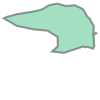

In [12]:
import fiona
from shapely.geometry import shape, Polygon


with fiona.open(shapefile_path) as f:
    for shape_zipcode in f:
        if shape_zipcode['properties']['zipcode'] == '31000':
            geometry_wkt = shape(shape_zipcode['geometry'])
            break

print("Zipcode 31000's WKT polygon is:")
print(geometry_wkt)

Polygon(geometry_wkt)

In [13]:
cql_filter = f"INTERSECTS(DIAS:footprint, {geometry_wkt}) " \
              "and DIAS:onlineStatus = ONLINE and DIAS:productType = GRD and DIAS:sensingStartDate &gt;= '2022-12-01T00:00:00' " \
              "and DIAS:sensingStartDate &lt; '2023-01-01T00:00:00'"
payload = payload_template.format(cql_filter=cql_filter)

ids = []
for i in range(3):
    response = requests.post(url_template.format(collection='Sentinel1'),
                         data=payload,
                         headers={"Content-Type": "application/xml"})

    root = etree.fromstring(response.content)
    ids += [x.text for x in root.findall('csw:SearchResults/csw:Record/dc:identifier', namespaces=root.nsmap)]
    
    # update startPosition
    next_record = root.find('csw:SearchResults', namespaces=root.nsmap).attrib['nextRecord']
    if next_record == "0":
        break
    
    root_payload = etree.fromstring(payload)
    root_payload.attrib["startPosition"] = next_record
    payload = etree.tostring(root_payload)
    
total_results = root.find('csw:SearchResults', namespaces=root.nsmap).attrib['numberOfRecordsMatched']
    
print(f'We got {len(ids)} records and found a total of {total_results} records')
print('\n'.join(ids))

We got 12 records and found a total of 12 records
S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498
S1B_IW_GRDH_1SDV_20191204T060001_20191204T060026_019211_02445A_9B52
S1B_IW_GRDH_1SDV_20191205T174655_20191205T174720_019233_0244FC_97CB
S1B_IW_GRDH_1SDV_20191205T174630_20191205T174655_019233_0244FC_6602
S1B_IW_GRDH_1SDV_20191216T060000_20191216T060025_019386_0249E7_B5DD
S1B_IW_GRDH_1SDV_20191217T174630_20191217T174655_019408_024A92_2E97
S1B_IW_GRDH_1SDV_20191217T174655_20191217T174720_019408_024A92_1ED6
S1A_IW_GRDH_1SDV_20191222T060056_20191222T060121_030457_037C89_F4F2
S1B_IW_GRDH_1SDV_20191228T060000_20191228T060025_019561_024F78_B8CA
S1B_IW_GRDH_1SDV_20191229T174630_20191229T174655_019583_025024_ACA1
S1B_IW_GRDH_1SDV_20191229T174655_20191229T174720_019583_025024_4A4B
S1A_IW_GRDH_1SDV_20191223T174719_20191223T174744_030479_037D53_2DE9


## Data download

Now that we know how to search products of interests and to get links to download their archives, let's do it!

### With boto3

We'll use a Python library named [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) that makes S3 buckets managing pretty easy.

In [14]:
import boto3

endpoint = 'https://obs.eu-de.otc.t-systems.com'
s3_client = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key, endpoint_url=endpoint)

Let's use a URI of a product found in our latest request.

In [15]:
record = root.find('csw:SearchResults/csw:Record', namespaces=root.nsmap)
archive_uri = record.find('DIAS:archiveProductURI', namespaces=record.nsmap).text

#### List bucket contents

Let's use our S3 client to list our record's bucket contents. Some documentation about client objects [here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#client).

In [16]:
_, bucket, prefix = archive_uri.replace(endpoint, '').split('/', 2)
print(f'archive URI: {archive_uri}\nbucket: {bucket}\nprefix: {prefix}\n')

listing_result = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
first_res = listing_result['Contents'][0]
nb_objects = len(listing_result['Contents'])

print(f'Listing result is a dict with following keys: {", ".join(x for x in listing_result.keys())}\n')
print(f'Found objects are in a list stored under "Contents" key. The first object is the following:\n{first_res}\n')
print(f"There are {nb_objects} objects matched with this prefix, ie, this product's archive consists of {nb_objects} objects")

archive URI: https://obs.eu-de.otc.t-systems.com/s1-l1-grd-2019-q4/2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498
bucket: s1-l1-grd-2019-q4
prefix: 2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498

Listing result is a dict with following keys: ResponseMetadata, IsTruncated, Contents, Name, Prefix, MaxKeys

Found objects are in a list stored under "Contents" key. The first object is the following:
{'Key': '2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498.SAFE-report-20191210T110821.pdf', 'LastModified': datetime.datetime(2019, 12, 10, 11, 54, 36, 511000, tzinfo=tzlocal()), 'ETag': '"6468077a50025ab0d1ff56c0b1b87545"', 'Size': 20139, 'StorageClass': 'STANDARD_IA'}

There are 22 objects matched with this prefix, ie, this product's archive consists of 22 objects


We can list all the objects for this product and select the first GTiff we find in order to download it later.

In [17]:
tiff = None
for obj in listing_result['Contents']:
    key = obj['Key']
    if key.endswith('tiff'):
        tiff = tiff or key  # only update if it's not been done yet
    print(key)
    
print(f'\nOur first GTiff is: {tiff}')

2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498.SAFE-report-20191210T110821.pdf
2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498/annotation/calibration/calibration-s1a-iw-grd-vh-20191210t060056-20191210t060121-030282-03767b-002.xml
2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498/annotation/calibration/calibration-s1a-iw-grd-vv-20191210t060056-20191210t060121-030282-03767b-001.xml
2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498/annotation/calibration/noise-s1a-iw-grd-vh-20191210t060056-20191210t060121-030282-03767b-002.xml
2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03767B_2498/annotation/calibration/noise-s1a-iw-grd-vv-20191210t060056-20191210t060121-030282-03767b-001.xml
2019/12/10/IW/DV/S1A_IW_GRDH_1SDV_20191210T060056_20191210T060121_030282_03

#### Download files

Now we're going to download the object to a file.

In [18]:
from os import path

filename = path.join('/home/jovyan/work', path.basename(tiff))
if not path.exists(filename):
    s3_client.download_file(Bucket=bucket, Key=tiff, Filename=filename)

### Via WMS requests

Web Map Service (WMS) is an Open Geospatial Consortium (OGC) standard that enables requesting maps from a server.

At Mundi we develop a Python module, _mundilib_, that makes some features easier to use, in particular our WMS.

#### WMS objects

With _mundilib_, we can easily get a WMS object for our Sentinel 1 GRD collection. From this object we can get some information like the implemented WMS version our supported operations and their supported formats.

In [19]:
import mundilib

catalog = mundilib.MundiCatalogue()
wms = catalog.get_collection('Sentinel1').mundi_wms('GRD')

print(f'Type: {wms.identification.type}')
print(f'Version: {wms.identification.version}')
print(f'Title: {wms.identification.title}')
print()
print(f'Abstract: {wms.identification.abstract}')

Type: WMS
Version: 1.3.0
Title: Sentinel-1 GRD

Abstract: The Copernicus project’s Sentinel satellites are revolutionizing earth observation (EO). Its free, full and open access to data with very short revisit times, high spatial resolution, and good spectral resolution are crucial for many applications. The portfolio of possible products is vast - use-cases of such a service range from plant health monitoring, land and water body change, flood monitoring, disaster mapping and more.However the current gap between Sentinel source data and its end-users is large:•   ESA’s complex Scientific Data Hub•   raster files are compressed with JPEG2000 (13 raster filesfor each product, one per spectral band)•   terabytes of data per week•   additional processing requirementsTackling the data in an old-fashioned way -  offering individual derivative products simply does not work anymore, the associated time and costs are large and defeat most of the major benefits of the Sentinel project.Our a

In [20]:
for operation in wms.operations:
    print(f'{operation.name}: {operation.methods}')
    print('\tFormat options:')
    for format_opts in operation.formatOptions:
        print(f'\t\t{format_opts}')
    print()

GetCapabilities: [{'type': 'Get', 'url': 'http://shservices.mundiwebservices.com/ogc/wms/88b68ca0-1f84-4286-8359-d3f480771de5?'}]
	Format options:
		application/xml
		text/xml
		application/vnd.ogc.wms_xml

GetMap: [{'type': 'Get', 'url': 'http://shservices.mundiwebservices.com/ogc/wms/88b68ca0-1f84-4286-8359-d3f480771de5?'}]
	Format options:
		image/png
		image/jpeg
		image/jpg
		image/tiff
		application/vnd.google-earth.kmz+xml
		image/tiff;depth=8
		image/tiff;depth=16
		image/tiff;depth=32f
		application/vnd.google-earth.kmz+xml;image_type=image/jpeg
		application/vnd.google-earth.kmz+xml;image_type=image/png
		application/x-esri-shape
		application/json

GetFeatureInfo: [{'type': 'Get', 'url': 'http://shservices.mundiwebservices.com/ogc/wms/88b68ca0-1f84-4286-8359-d3f480771de5?'}]
	Format options:
		application/xml
		text/xml
		application/vnd.ogc.wms_xml
		application/vnd.ogc.gml
		text/html
		application/json
		text/plain



#### Available layers

Let's take a look at all available layers.

In [21]:
for lay in wms.contents:
    print(f'{wms[lay].name} => {wms[lay].title}')

IW_VV => IW - VV [linear gamma0]
IW-SV-LINEAR-GAMMA0 => IW - SV [linear gamma0]
IW_VV_DB => IW - VV [dB gamma0]
IW-SV-DB-GAMMA0 => IW - SV [dB gamma0]
IW_VH => IW - VH [linear gamma0]
IW-VH-DB => IW - VH [dB gamma0]
EW-HH-LINEAR-GAMMA0 => EW - HH [linear gamma0]
EW-HH-DB-GAMMA0 => EW - HH [dB gamma0]
EW-SH-LINEAR-GAMMA0 => EW - SH [linear gamma0]
EW-SH-DB-GAMMA0 => EW - SH [dB gamma0]
EW_HV => EW - HV [linear gamma0]
EW_HV_DB => EW - HV [dB gamma0]


#### Layers attributes

As for the WMS object, we can get information on a layer by reading its attributes.

In [22]:
layer = wms[list(wms.contents)[0]]

print(f'Name: {layer.name}')
print(f'Title: {layer.parent.title}')
print(f'Abstract: {layer.abstract}')
print(f'BBox: {layer.boundingBoxWGS84}')
print(f'CRS: {layer.crsOptions}')
print(f'Styles: {layer.styles}')
print(f'Timestamps: {layer.timepositions}')

Name: IW_VV
Title: Sentinel Hub WMS
Abstract: None
BBox: (-180.0, -90.0, 180.0, 90.0)
CRS: ['EPSG:32738', 'EPSG:32625', 'EPSG:32612', 'EPSG:32614', 'EPSG:32616', 'EPSG:32617', 'EPSG:32703', 'EPSG:32647', 'EPSG:32750', 'EPSG:32604', 'EPSG:27700', 'EPSG:32641', 'EPSG:32646', 'EPSG:3031', 'EPSG:32603', 'EPSG:32659', 'EPSG:32707', 'EPSG:3794', 'EPSG:3346', 'EPSG:32602', 'EPSG:32650', 'EPSG:32718', 'EPSG:32709', 'EPSG:32715', 'EPSG:32620', 'EPSG:32745', 'EPSG:32611', 'EPSG:32609', 'EPSG:32630', 'EPSG:32637', 'EPSG:32639', 'EPSG:32752', 'EPSG:32702', 'EPSG:32655', 'EPSG:32701', 'EPSG:32754', 'EPSG:32753', 'EPSG:32624', 'EPSG:32757', 'EPSG:32636', 'EPSG:32740', 'EPSG:32741', 'EPSG:32627', 'EPSG:32618', 'EPSG:32619', 'EPSG:32721', 'EPSG:32657', 'EPSG:32644', 'EPSG:3857', 'EPSG:4326', 'EPSG:32729', 'EPSG:32712', 'EPSG:32758', 'EPSG:32736', 'EPSG:32649', 'EPSG:32725', 'EPSG:3004', 'EPSG:32605', 'EPSG:32717', 'EPSG:32756', 'EPSG:32734', 'SR-ORG:98739', 'EPSG:32638', 'EPSG:4026', 'EPSG:32751', 'EP

#### Usage

All this is interesting, but let's get to the real work! We're going to use our WMS object to request some data.

IW - VV [linear gamma0]


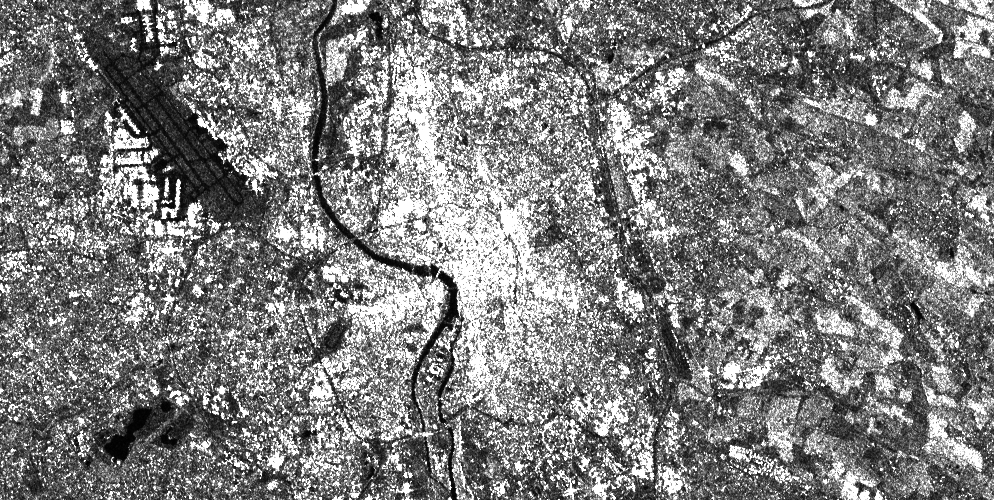

IW - SV [linear gamma0]


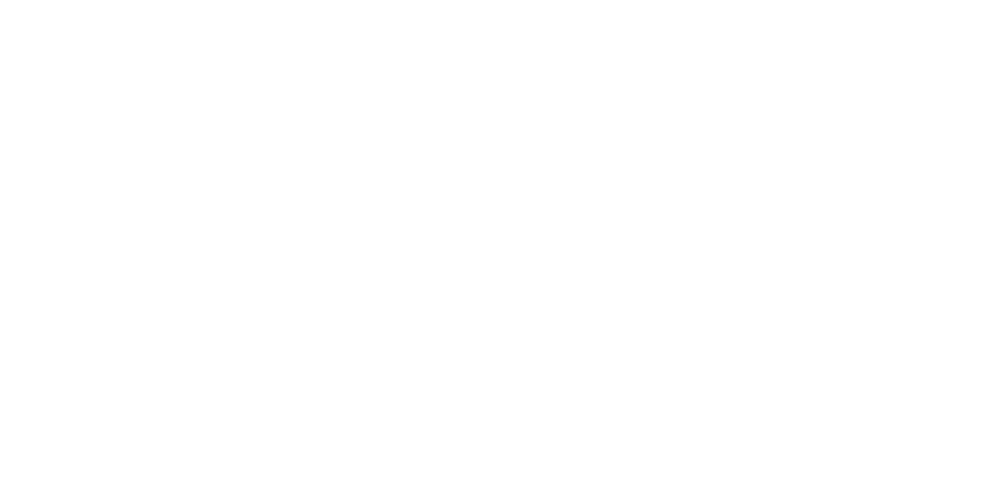

IW - VV [dB gamma0]


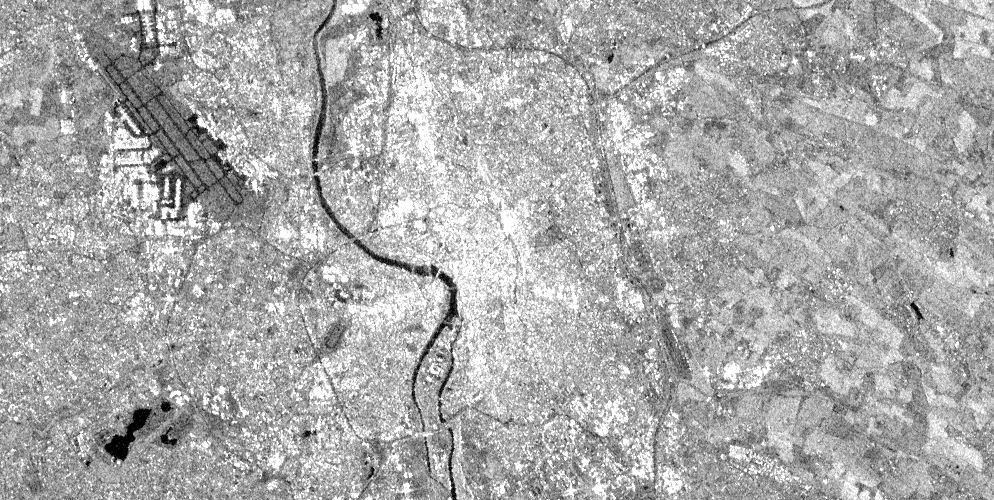

IW - SV [dB gamma0]


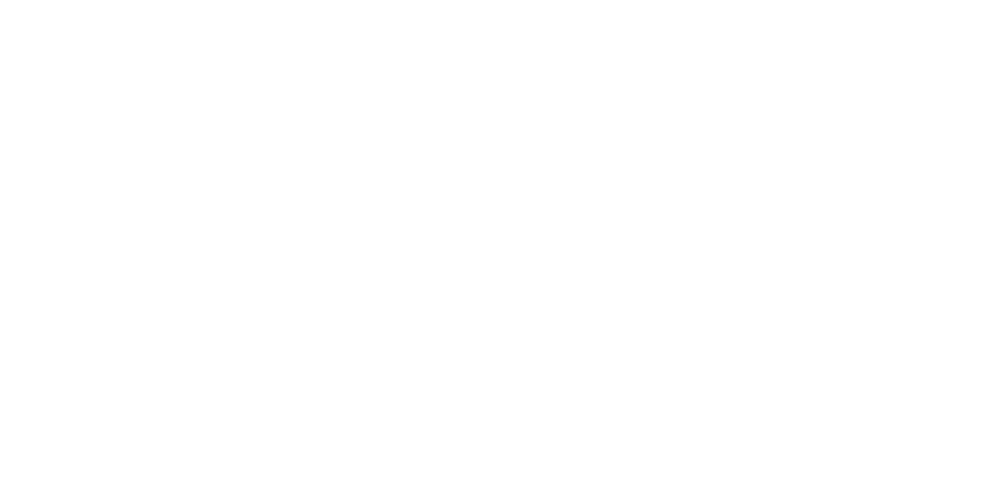

IW - VH [linear gamma0]


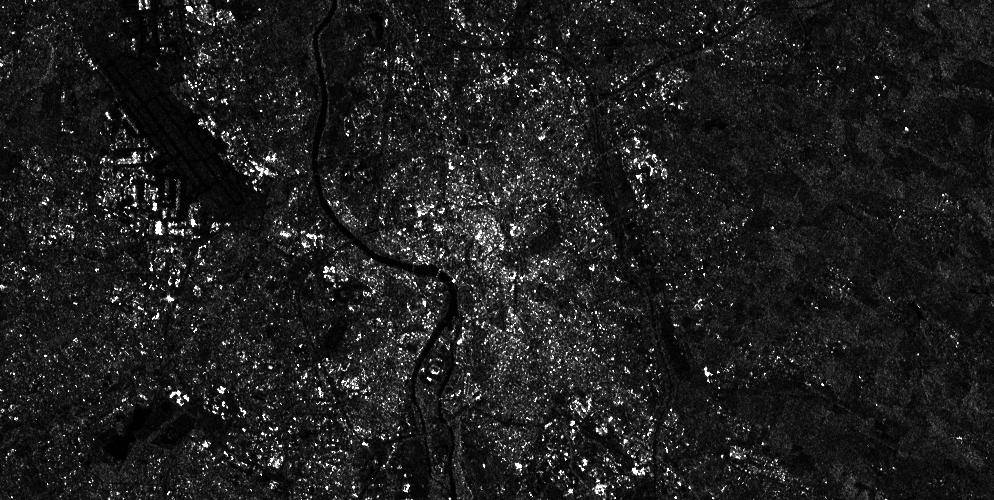

IW - VH [dB gamma0]


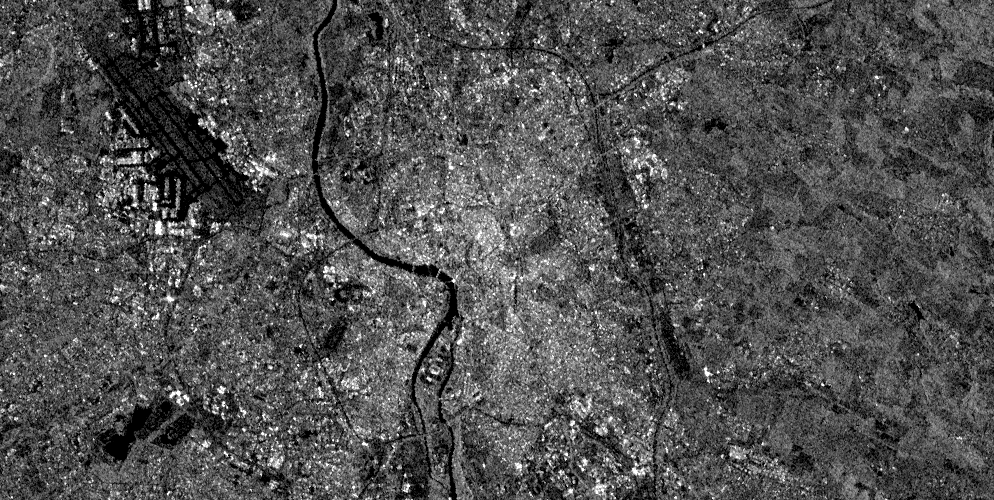

EW - HH [linear gamma0]


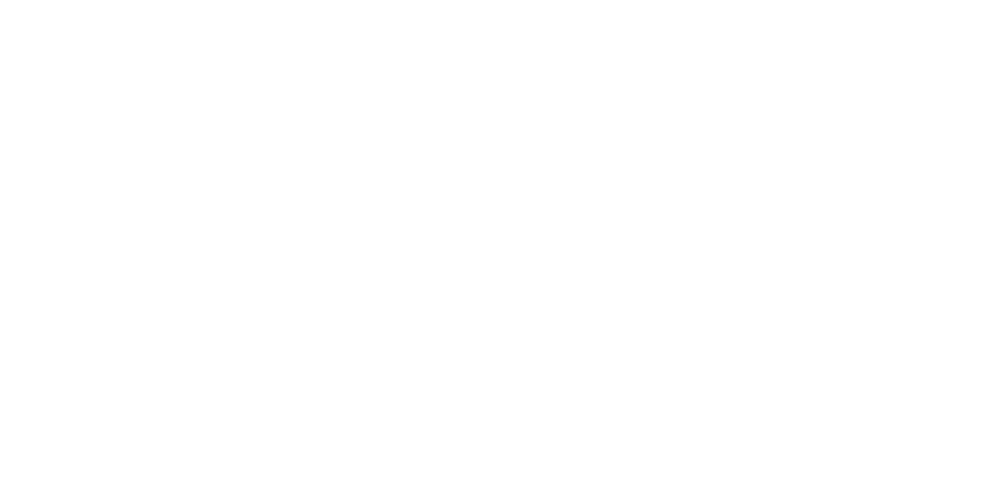

EW - HH [dB gamma0]


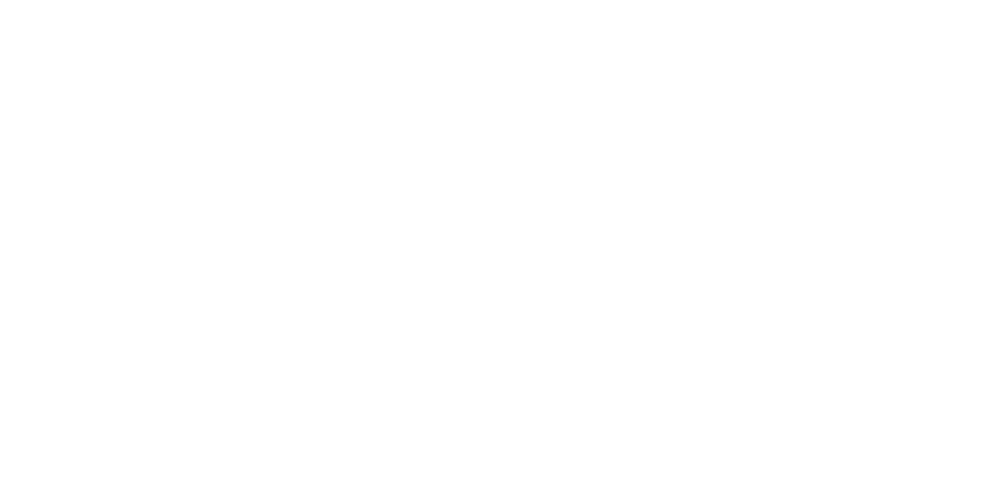

EW - SH [linear gamma0]


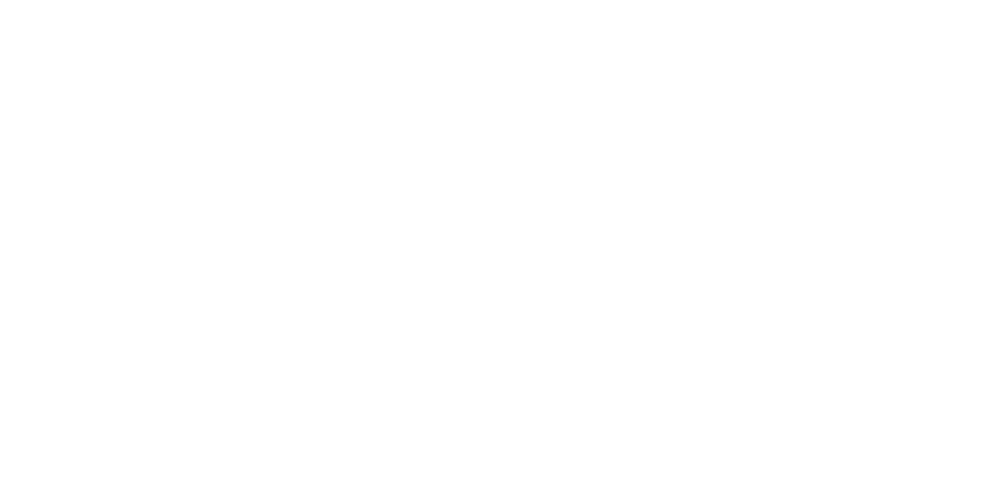

EW - SH [dB gamma0]


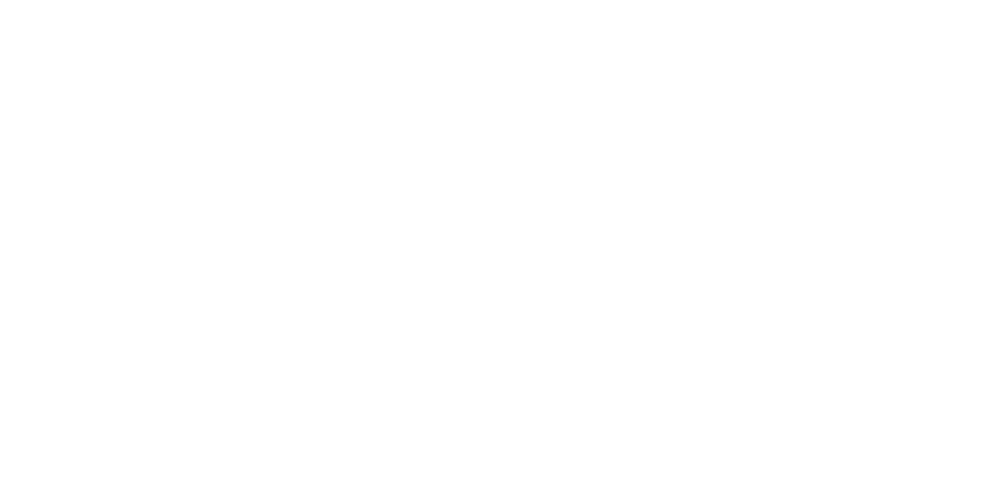

EW - HV [linear gamma0]


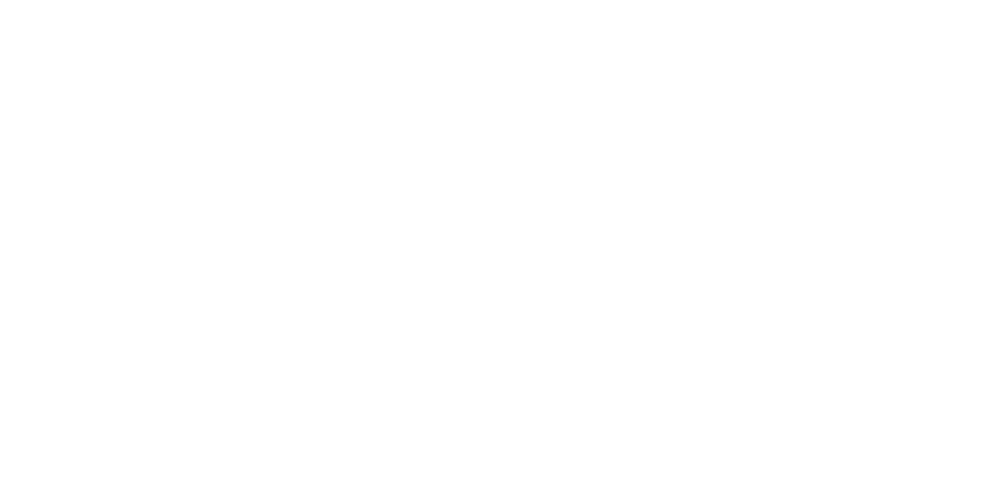

EW - HV [dB gamma0]


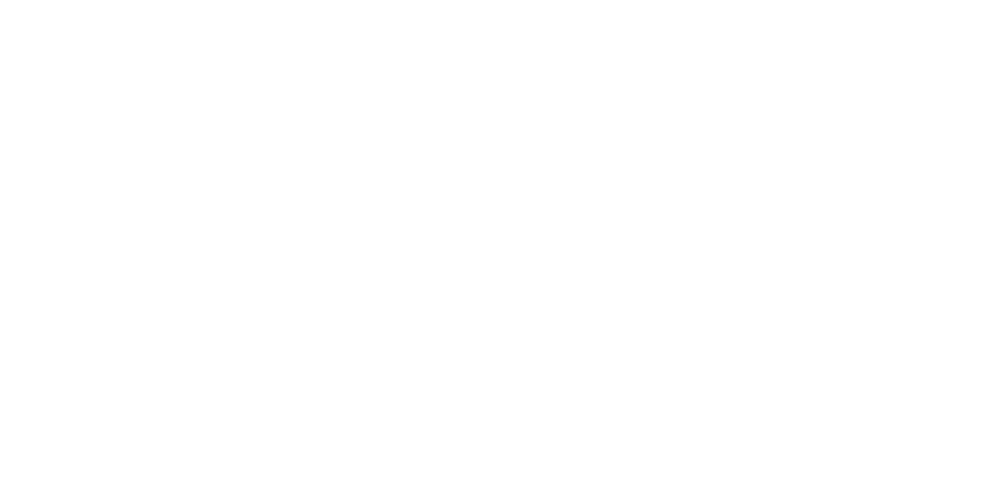

In [23]:
from PIL import Image
from utils import height2width

bbox = 146453.3462, 5397218.5672, 176703.3001, 5412429.5358
projection = 'EPSG:3857'
date = '2022-12-25'

height = 500
width = height2width(bbox, height)

for layer_name in wms.contents:
    layer = wms[layer_name]
    print(layer.title)
    
    img = wms.getmap(layers = [layer.name],
                     srs = projection,
                     bbox = bbox,
                     size = (width, height),
                     format ='image/png',
                     time = date,
                     showlogo = False)
    
    display(Image.open(img))

We can see from the above ouput that some layers are blank images. This is because interferometric wide (IW) products are senses using VV and VH polarizations, therefore all other polarizations have no data.

## Data cropping

When we used boto3, we downloaded an entire file whereas we might be interested in only a small part of this file. 

We will know learn how to clip data to our AOI which is defined in a shapefile. Many ways exist to achieve that. We'll use GDAL's Python bindings.

Since we filtered catalog results above to get data intersecting Toulouse 31000 zipcode, let's crop the data to this area.

In [24]:
%matplotlib inline

In [25]:
import numpy as np
from matplotlib import pyplot as plt

from osgeo import gdal

In [26]:
filename_clipped = path.join('/home/jovyan/work', f'clip_{path.basename(tiff)}')

ds = gdal.Open(filename)
print(f'Shape before cropping: {ds.GetRasterBand(1).ReadAsArray().shape}')

projection = ds.GetProjectionRef()
output = gdal.Warp(
    filename_clipped,  # ouput filename
    ds,  # input GDAL dataset object
    format='GTiff',  # output format
    cutlineDSName=shapefile_path,  # shapefile path
    dstSRS=projection,  # output CRS
    cropToCutline=True  # whether to fit output bounds to shape's extent
)

data = output.GetRasterBand(1).ReadAsArray()
print(f'Shape after cropping: {data.shape}')

Shape before cropping: (16668, 26419)
Shape after cropping: (205, 386)


Now let's take a look at the result: GDAL's warp wrote the clipped data to a file for us.

In [27]:
def show_array(array):
    array = array.astype(float)
    
    # decrease extreme values to a threshold value
    vectorized = array.reshape(array.size, 1)
    threshold = np.percentile(vectorized, 96)
    array[array > threshold] = threshold
    
    # normalize values between 0 and 255
    coeff = 255 / threshold
    array *= coeff
    array = array.astype(np.uint8)
    
    # show image with pyplot
    plt.imshow(array, cmap='gray', vmin=0, vmax=255)
    plt.show()

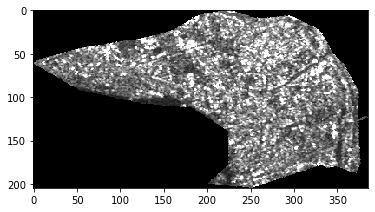

In [28]:
show_array(data)

## Data upload 

Once data is retrieved, clipped to AOI and if needed preprocessed, we might want to store it in a bucket. In order to do that, we'll use boto3 library once again. You will need to create your own bucket beforehand.

In [29]:
bucket = 'name_of_your_bucket'
key = f'your_path/{path.basename(filename_clipped)}'

In [30]:
s3_client.upload_file(filename_clipped, bucket, key)

Let's check that the file has been uploaded.

In [31]:
listing = s3_client.list_objects_v2(Bucket=bucket, Prefix=key)

print(f'Found {len(listing["Contents"])} object...')

file_key = listing['Contents'][0]['Key']
print(f'... which is stored at s3://{bucket}/{file_key}')

Found 1 object...
... which is stored at s3://mundi-tests-01/test_upload_notebook//home/jovyan/work/clip_s1a-iw-grd-vh-20191210t060056-20191210t060121-030282-03767b-002.tiff


Everything is OK!

Note: there's another function, [*put_object*](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.put_object) that gives much more control over the upload, in particular about permissions and storage class.